In [1]:
import pandas as pd

matches = pd.read_csv("atp_matches_2019.csv")
atp_players = pd.read_csv("atp_players.csv")
atp_rankings_10s = pd.read_csv("atp_rankings_10s.csv")

year = 2019
matches_file_name = "atp_matches_2019_cleaned.csv"
output_gz_path = "graph2019.gz"
output_gml_path = "graph2019.gml"

In [2]:
import networkx as nx

import collections
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt

import math

from networkx.algorithms import community as comm
import itertools

from operator import itemgetter

import string

import numpy as np

from sklearn import cluster

import copy

# Ciscenje podataka

## Brisanje grupnih turnira

In [3]:
matches = matches[['tourney_id','tourney_name','winner_id','loser_id','surface']]

indexes=[]
for index,tourney_id,tourney_name,winner_id,loser_id,surface in matches.itertuples():
    if ("Davis Cup" in tourney_name):
        indexes.append(index)        
        
matches = matches.drop(indexes)  

In [4]:
from datetime import date

def get_num_of_days_between(start_date_int,end_date_int):
    start_date = date(int(start_date_int/10000), int(int(start_date_int%10000)/100), int(start_date_int%100))
    end_date = date(int(end_date_int/10000), int(int(end_date_int%10000)/100), int(end_date_int%100))
    difference = end_date - start_date
    return difference.days

def get_player_ranking(id,year):
    next_year=(year+1)*10000
    year*=10000
    ranks = atp_rankings_10s[(atp_rankings_10s['player']==id) & (atp_rankings_10s['ranking_date']>=year) & (atp_rankings_10s['ranking_date']<next_year)]
    ranks=ranks.reset_index()
    days_sum=0
    calc_rank=0
    for i in range(len(ranks)-1):
        rank = ranks.loc[i,'rank']
        start_date = ranks.loc[i,'ranking_date']
        end_date = ranks.loc[i+1,'ranking_date']
        days = get_num_of_days_between(start_date,end_date)
        calc_rank += rank*days
        days_sum +=days   
    return calc_rank/days_sum if days_sum != 0 else float('NaN')

In [5]:
winners = set(matches['winner_id'].unique())
losers = set(matches['loser_id'].unique())

players_ids = winners.union(losers)
print(f"Postoji { len(players_ids) } različitih igrača") 

players_with_attr_list = [(player_id,first_name+' '+last_name,country_code,get_player_ranking(player_id,year)) for _,player_id,first_name,last_name,hand,birth_date,country_code in atp_players.itertuples() if player_id in players_ids]
players_with_attr = pd.DataFrame(players_with_attr_list,columns =['player_id', 'player_name','country_code','rank'])

players = (players_with_attr.set_index('player_id')).to_dict('index')
#players = players.set_index('player_id')
#players = pd.DataFrame.from_dict(players_with_attr.set_index('player_id').to_dict('index'),orient='index')

Postoji 281 različitih igrača


## Cuvanje sekundarnog skupa podataka

In [6]:
matches.to_csv(matches_file_name, index = False, header=True)
#pd.DataFrame.from_dict(players,orient='index').to_csv(players_file_name, index = True, header=True)

# Modelovanje grafova

In [7]:
G = nx.Graph()
G.add_nodes_from(players_ids)

nx.set_node_attributes(G, players)

### Dodavanje tezinskih grana 

In [8]:
edge_data = matches[['winner_id','loser_id']]
for _,winner_id,loser_id in edge_data.itertuples():
    if (winner_id, loser_id) in G.edges:
        G.edges[winner_id, loser_id]['weight'] += 1
    else:
        G.add_edge(winner_id, loser_id, weight=1)
        
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 281
Number of edges: 2215
Average degree:  15.7651


## Pomocni graf turnira 

In [9]:
tourney_graph = nx.Graph()

tourney_graph.add_nodes_from(players_ids, node_type='player')
nx.set_node_attributes(tourney_graph, players)

tourney_names = matches['tourney_name'].unique()
tourney_graph.add_nodes_from(tourney_names, node_type='tourney')  

## Dodavanje tezinskih grana 

In [10]:
edge_data = matches[['winner_id','loser_id','tourney_name']]
for _,winner_id,loser_id,tourney_name in edge_data.itertuples():
    if (winner_id, tourney_name) in tourney_graph.edges:
        tourney_graph.edges[winner_id, tourney_name]['weight'] += 1
    else:
        tourney_graph.add_edge(winner_id, tourney_name, weight=1)
    if (loser_id, tourney_name) in tourney_graph.edges:
        tourney_graph.edges[loser_id, tourney_name]['weight'] += 1
    else:
        tourney_graph.add_edge(loser_id, tourney_name, weight=1)  
        
print(nx.info(tourney_graph))

Name: 
Type: Graph
Number of nodes: 347
Number of edges: 2667
Average degree:  15.3718


## Surface atribut

In [11]:
tourney_nodes = [node for node, node_type in tourney_graph.nodes(data='node_type') if node_type=='tourney']

for tourney in tourney_nodes:
    tourney_graph.nodes[tourney]['surface'] = matches[matches['tourney_name']==tourney].iloc[0].surface

# Pomocne metode (uz modelovan graf)

In [12]:
def get_player_by_name(player_name):
    nodes = [node for node,name in G.nodes(data='player_name') if name==player_name]
    player = 0
    if len(nodes)>0:
        player = nodes[0]
    return player

def get_players_matches(id):
    mask = (matches['winner_id']==id) | (matches['loser_id']==id)
    return matches[mask]

In [13]:
def get_nodes_by_attribute(G,attribute, value):
    return [n for n,v in G.nodes(data=True) if v[attribute] == value]

In [14]:
def get_players_degrees(G,players):
    return [(node,name,G.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

In [15]:
def get_player_attribute(G,player,attribute):
    return [v[attribute] for n,v in G.nodes(data=True) if  n== player]

In [16]:
def get_player_info(id):
    return (id,G.nodes[id]['player_name'],G.nodes[id]['rank'],G.nodes[id]['country_code'])
    #return tuple([(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True) if node==id])

def get_players_info(players):
    infos = []
    for player in players:
        infos.append(get_player_info(player))
    return infos  

In [17]:
def get_players_opponents_info(id):
    opponents = nx.node_connected_component(G, id)
    return get_players_info(opponents)

In [18]:
def plot_deg_frequency(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(degree))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(degree, frequency, marker='.')                                                                                                    
    plt.show()

# Istrazivacka pitanja

# 1. Koliki je prosečan broj tenisera (saigrača) po svakom teniseru?

In [19]:
def get_average_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree()) / float(num_of_nodes)
    return degree

def get_average_weighted_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree(weight='weight')) / float(num_of_nodes)
    return degree  

In [20]:
print(f"Prosecan broj saigraca svakog tenisera: {get_average_degree(G)}")   

Prosecan broj saigraca svakog tenisera: 15.765124555160142


In [21]:
print(f"Prosecan broj meceva svakog tenisera: {get_average_weighted_degree(G)}")

Prosecan broj meceva svakog tenisera: 18.569395017793596


# 2. Koji teniseri su se susretali sa najvećim brojem drugih tenisera? 

In [22]:
degrees = [G.degree(node) for node in G.nodes()]
max_degree = max(degrees)

players_degrees = [(node,name,G.degree(node)) for (node,name) in G.nodes(data='player_name')]

high_degree_players = (sorted(players_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Max stepen: {max_degree}")
print(f"Igraci koji su igrali sa najvise drugih igraca: {high_degree_players}")

Max stepen: 59
Igraci koji su igrali sa najvise drugih igraca: [(106421, 'Daniil Medvedev', 59), (126774, 'Stefanos Tsitsipas', 51), (105332, 'Benoit Paire', 50), (100644, 'Alexander Zverev', 49), (106043, 'Diego Sebastian Schwartzman', 49), (105676, 'David Goffin', 47), (126203, 'Taylor Harry Fritz', 47), (104745, 'Rafael Nadal', 47), (126610, 'Matteo Berrettini', 47), (106233, 'Dominic Thiem', 47)]


In [23]:
[(p[1],(p[2])) for p in high_degree_players]

[('Daniil Medvedev', 59),
 ('Stefanos Tsitsipas', 51),
 ('Benoit Paire', 50),
 ('Alexander Zverev', 49),
 ('Diego Sebastian Schwartzman', 49),
 ('David Goffin', 47),
 ('Taylor Harry Fritz', 47),
 ('Rafael Nadal', 47),
 ('Matteo Berrettini', 47),
 ('Dominic Thiem', 47)]

# 3. Koji teniseri su učestvovali na najvećem broju (različitih) turnira?

In [24]:
player_tourney_degrees = [(node,name,tourney_graph.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

high_tourney_degree_players = (sorted(player_tourney_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Igraci koji su ucestvovali na najvecem broju turnira: {high_tourney_degree_players}")

Igraci koji su ucestvovali na najvecem broju turnira: [(105332, 'Benoit Paire', 30), (126203, 'Taylor Harry Fritz', 29), (104468, 'Gilles Simon', 28), (105311, 'Joao Sousa', 28), (105526, 'Jan Lennard Struff', 27), (105583, 'Dusan Lajovic', 27), (104871, 'Jeremy Chardy', 27), (105173, 'Adrian Mannarino', 27), (126774, 'Stefanos Tsitsipas', 27), (104269, 'Fernando Verdasco', 27)]


# 4. Koji teniseri su dobri kandidati za predstavnike profesionalnih tenisera? 
## Da li i šta se menja ukoliko se umesto jednog bira skup od nekoliko predstavnika?
### Dobar predstavnik ili predstavnici bi trebalo da budu u kontaktu sa što većim skupom tenisera.

In [25]:
#Mozda po lokalnoj centralnosti? - Čvor je lokalno centralan ako ima veći broj veza sa svojim okruženjem
degree_centralities = [(node, centrality) for node, centrality in nx.degree_centrality(G).items()]

max_degree_centralities = sorted(degree_centralities,key=lambda item: item[1], reverse=True)[:10]

high_degree_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_degree_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_degree_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[((106421, 'Daniil Medvedev', 10.352941176470589, 'RUS'), 0.21071428571428572),
 ((126774, 'Stefanos Tsitsipas', 8.0, 'GRE'), 0.18214285714285713),
 ((105332, 'Benoit Paire', 39.01960784313726, 'FRA'), 0.17857142857142858),
 ((100644, 'Alexander Zverev', 4.96078431372549, 'GER'), 0.175),
 ((106043, 'Diego Sebastian Schwartzman', 20.11764705882353, 'ARG'), 0.175),
 ((105676, 'David Goffin', 19.058823529411764, 'BEL'), 0.16785714285714284),
 ((126203, 'Taylor Harry Fritz', 39.411764705882355, 'USA'),
  0.16785714285714284),
 ((104745, 'Rafael Nadal', 1.8431372549019607, 'ESP'), 0.16785714285714284),
 ((126610, 'Matteo Berrettini', 29.58823529411765, 'ITA'),
  0.16785714285714284),
 ((106233, 'Dominic Thiem', 5.098039215686274, 'AUT'), 0.16785714285714284)]

In [26]:
#Eigenvector centrality - Varijanta centralnosti po stepenu koja uzima u obzir i susedstvo posmatranog čvora
#onaj sa najvecom plus njegovi susedi??
eigenvector_centralities = [(node, centrality) for node, centrality in nx.eigenvector_centrality(G).items()]

#prvih 10
max_eigenvector_centralities = sorted(eigenvector_centralities,key=lambda item: item[1], reverse=True)[:10]

high_eigenvector_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_eigenvector_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_eigenvector_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[((106421, 'Daniil Medvedev', 10.352941176470589, 'RUS'), 0.1648643221063789),
 ((126774, 'Stefanos Tsitsipas', 8.0, 'GRE'), 0.14399491996426636),
 ((100644, 'Alexander Zverev', 4.96078431372549, 'GER'), 0.14142284572281316),
 ((126610, 'Matteo Berrettini', 29.58823529411765, 'ITA'),
  0.13745593185915114),
 ((105676, 'David Goffin', 19.058823529411764, 'BEL'), 0.13713444509621753),
 ((106233, 'Dominic Thiem', 5.098039215686274, 'AUT'), 0.13565465045625882),
 ((103819, 'Roger Federer', 3.549019607843137, 'SUI'), 0.13527813799004343),
 ((104745, 'Rafael Nadal', 1.8431372549019607, 'ESP'), 0.13417242354969422),
 ((106043, 'Diego Sebastian Schwartzman', 20.11764705882353, 'ARG'),
  0.13263222408608297),
 ((105526, 'Jan Lennard Struff', 41.98039215686274, 'GER'),
  0.12906962467461677)]

# 5. Kako su rangirani na ATP listi teniseri koji su se susretali sa najvećim brojem drugih tenisera?

In [27]:
high_degree_players_ids = list(list(zip(*high_degree_players))[0])

high_degree_players_ranks = [(node,attr['player_name'],G.degree(node),attr['rank']) for (node,attr) in G.nodes(data=True) if node in high_degree_players_ids]
high_degree_players_ranks = sorted(high_degree_players_ranks,key=lambda item: item[3])
high_degree_players_ranks

[(104745, 'Rafael Nadal', 47, 1.8431372549019607),
 (100644, 'Alexander Zverev', 49, 4.96078431372549),
 (106233, 'Dominic Thiem', 47, 5.098039215686274),
 (126774, 'Stefanos Tsitsipas', 51, 8.0),
 (106421, 'Daniil Medvedev', 59, 10.352941176470589),
 (105676, 'David Goffin', 47, 19.058823529411764),
 (106043, 'Diego Sebastian Schwartzman', 49, 20.11764705882353),
 (126610, 'Matteo Berrettini', 47, 29.58823529411765),
 (105332, 'Benoit Paire', 50, 39.01960784313726),
 (126203, 'Taylor Harry Fritz', 47, 39.411764705882355)]

# 6.  Iz kojih zemalja dolazi najveći broj aktivnih igrača u proteklom periodu?

In [28]:
def plot_players_per_country_frequency(G, xscale = "linear", yscale = "linear"):

    countries = [country for node,country in G.nodes(data='country_code')]
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                      

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    plt.ylabel('Country')
    plt.xlabel('num of players')
    plt.show()

In [29]:
#plot_players_per_country_frequency(G)

# 7. Iz kojih zemalja dolaze najuspešniji igrači u smislu osvojenih poena na ATP listi?

In [30]:
def get_first_atp_players(num):
    player_ranks = [(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True)]

    player_ranks = (list(filter(lambda x: math.isnan(x[2])==False, player_ranks)))
    player_ranks = (sorted(player_ranks, key=lambda element: (element[2]),reverse=False))[:num]
    return player_ranks
    

In [31]:
def plot_best_players_per_country_frequency(countries, xscale = "linear", yscale = "linear"):
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                    

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    plt.ylabel('Country')
    plt.xlabel('num of players')
    plt.show()

In [32]:
countries = get_first_atp_players(100)
_,_,_,countries = zip(*countries)

#za USA se dosta vidi razlika u 100 i 1000
#ali se pitanje odnosi na najuspesnije
#plot_best_players_per_country_frequency(countries)

# 8. Kako su u okviru skupa podataka okarakterisani igrači iz Srbije?

In [33]:
serbian_players = [player for player,country in G.nodes(data='country_code') if country=='SRB']

serbian_players_ranks = [(get_player_info(player)[1],rank) for player,rank in G.nodes(data='rank') if player in serbian_players]
print(f"Po ranku srpski igraci su: {serbian_players_ranks}\n")

serbian_players_matches = [(get_player_info(player)[1],degree) for player,degree in G.degree(weight='weight') if player in serbian_players]
print(f"Po broju meceva srpski igraci su: {serbian_players_matches}\n")

serbian_players_opponents = [(get_player_info(player)[1],degree) for player,degree in G.degree() if player in serbian_players]
print(f"Po broju saigraca srpski igraci su: {serbian_players_opponents}\n")


#Mozda u odnos na druge zemlje?

Po ranku srpski igraci su: [('Dusan Lajovic', 35.1764705882353), ('Nikola Milojevic', 163.05882352941177), ('Viktor Troicki', 191.88235294117646), ('Filip Krajinovic', 64.7843137254902), ('Novak Djokovic', 1.1568627450980393), ('Miomir Kecmanovic', 78.76470588235294), ('Pedja Krstin', 212.8235294117647), ('Laslo Djere', 42.68627450980392), ('Janko Tipsarevic', 306.6458333333333)]

Po broju meceva srpski igraci su: [('Dusan Lajovic', 46), ('Nikola Milojevic', 2), ('Viktor Troicki', 8), ('Filip Krajinovic', 44), ('Novak Djokovic', 66), ('Miomir Kecmanovic', 42), ('Pedja Krstin', 1), ('Laslo Djere', 43), ('Janko Tipsarevic', 18)]

Po broju saigraca srpski igraci su: [('Dusan Lajovic', 43), ('Nikola Milojevic', 2), ('Viktor Troicki', 8), ('Filip Krajinovic', 36), ('Novak Djokovic', 44), ('Miomir Kecmanovic', 36), ('Pedja Krstin', 1), ('Laslo Djere', 35), ('Janko Tipsarevic', 17)]



# 9. Koje zajednice (komune) se mogu uočiti prilikom analize mreže? Da li postoji neko objašnjenje za detektovane komune?

In [34]:
#Clauset-Newman-Moore pohlepni algoritam
communities = comm.greedy_modularity_communities(G, weight='weight')
communities = [list(community) for community in communities]

# communities_info = {}
# i=0
# for community in communities:
#     i+=1
#     communities_info[i] = get_players_info(community)

communities_info = {}
for i in range(0,len(communities)):
    communities_info[i+1] = get_players_info(communities[i])
    
#communities_info

# 10. Sprovesti analizu klasterisanja i asortativnu analizu, pa uporediti grupisanje na osnovu zemlje iz koje igrači dolaze, na osnovu broja mečeva koje igraju i na osnovu rejtinga.

# Analiza klasterisanja

In [35]:
#Lokalni koeficijent klasterizacije
#računa se kao gustina mreže koju čine posmatrani čvor, njegovi susedi i njihove međusobne veze

player_id, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

not_zero_cc_players = [(get_player_info(player),cc,degree[1])  for player, cc, degree in zip(player_id, clustering_coef, G.degree(weight='weight')) if cc > 0]
not_zero_cc_players = (sorted(not_zero_cc_players, key=lambda element: (element[1]),reverse=True))

max_local_clustering_coef = max(clustering_coef)

average_clustering_coef = nx.average_clustering(G)

print(f"Max lokalni cc: {max_local_clustering_coef}")
print(f"Prosečan cc: {average_clustering_coef}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
#not_zero_cc_players

Max lokalni cc: 0.2519842099789747
Prosečan cc: 0.1761883928149076
Lokalni stepeni klasterisanja koji nisu nula:


## Asortativnost 

In [36]:
# asortativnost na osnovu netežinskog stepena čvora
graph_ass = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {graph_ass}")

# asortativnost na osnovu težinskog stepena čvora
graph_weighted_ass = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): {graph_weighted_ass}")

#Umereno asortativna mreza? - vezivanje cvorova koji su slicni

# asortativnost na osnovu ranka
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'rank')
print(f"Koeficijent asortativnosti na osnovu ranka čvora: {graph_rank_ass}")

#U grupe??

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.10759828422148615
Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): 0.11951186141345967
Koeficijent asortativnosti na osnovu ranka čvora: -0.007379444940080508


In [37]:
max_rank = max([rank for (node,rank) in G.nodes(data='rank')])

def getRankGroup(rank):
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'theLastGroup'

def addRankGroupAttributes():
    for player in players:
        G.nodes[player]['rank_group']=getRankGroup(G.nodes[player]['rank'])

In [38]:
addRankGroupAttributes()

graph_rank_group_ass = nx.attribute_assortativity_coefficient(G, 'rank_group')
print(f"Koeficijent asortativnosti na osnovu kategorije ranka čvora: {graph_rank_group_ass}")

Koeficijent asortativnosti na osnovu kategorije ranka čvora: 0.0722282965169065


In [39]:
# asortativnost na osnovu drzave
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'country_code')
print(f"Koeficijent asortativnosti na osnovu drzave: {graph_rank_ass}")

Koeficijent asortativnosti na osnovu drzave: 0.004254590139861759


# 11. U kojoj meri teniseri imaju tendenciju da se susreću sa istim teniserima? Da li na to utiče njihovo rangiranje na ATP listi?


In [40]:
def plot_num_of_opponents_per_rank(G, xscale = "linear", yscale = "linear"):
     
    x=[]
    y=[]
    for node,rank in G.nodes(data='rank'):
        x.append(G.degree(weight='weight')[node]/G.degree[node])
        y.append(rank)

    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('rank')  
    plt.xlabel('broj meceva/broj protivnika') 
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))  
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

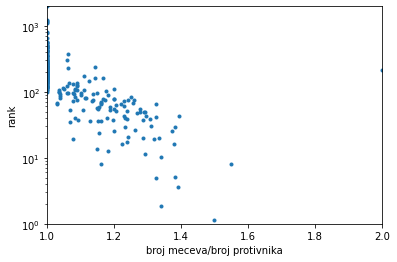

In [41]:
plot_num_of_opponents_per_rank(G,'linear','log')

# 12. Koji teniseri predstavljaju jezgro mreže?


In [42]:
from networkx.algorithms import core

core_graph = core.k_core(G)

print(nx.info(core_graph))

#da li je 78 od 219 jezgro?
core_nodes = [(node,name) for node,name in core_graph.nodes(data='player_name')]

#gustina znatno veca!
nx.density(core_graph)

Name: 
Type: Graph
Number of nodes: 83
Number of edges: 1204
Average degree:  29.0120


0.35380546576550104

# 13. Ko su teniseri koji povezuju različite grupe u okviru mreže?

In [43]:
betweenness_centralities = [(node, centrality) for node, centrality in nx.betweenness_centrality(G).items()]

max_betweenness_centralities = sorted(betweenness_centralities,key=lambda item: item[1], reverse=True)[:10]

high_betweenness_centralities_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_betweenness_centralities]

print(f"Teniseri koji povezuju različite grupe u okviru mreže")
high_betweenness_centralities_centrality_players

Teniseri koji povezuju različite grupe u okviru mreže


[((105311, 'Joao Sousa', 54.568627450980394, 'POR'), 0.04078519853908428),
 ((106148, 'Roberto Carballes Baena', 84.6470588235294, 'ESP'),
  0.03317825468531513),
 ((105807, 'Pablo Carreno Busta', 38.86274509803921, 'ESP'),
  0.03279814699548046),
 ((105550, 'Guido Pella', 30.07843137254902, 'ARG'), 0.029964356358097008),
 ((104269, 'Fernando Verdasco', 36.1764705882353, 'ESP'), 0.02932099314755331),
 ((126094, 'Andrey Rublev', 65.58823529411765, 'RUS'), 0.0278624834430481),
 ((111442, 'Jordan Thompson', 60.96078431372549, 'AUS'), 0.027463007305310823),
 ((106233, 'Dominic Thiem', 5.098039215686274, 'AUT'), 0.026570569259028336),
 ((104655, 'Pablo Cuevas', 57.88235294117647, 'URU'), 0.026333068354674423),
 ((105932, 'Nikoloz Basilashvili', 19.686274509803923, 'GEO'),
  0.02553264597305729)]

# 14. Kolika je gustina svake od modelovanih mreža?

In [44]:
nx.density(G)

0.05630401626842908

# 15. U kojoj meri su mreže povezane i centralizovane?

In [45]:
_,degrees = zip(*G.degree())

N=len(degrees)
max_degree = max(degrees)

#sum(max(x)-x)/(length(x)-1)
centralization = float((N*max_degree - sum(degrees)))/(N-1)**2

centralization

0.15496173469387756

In [46]:
def plot_players_per_centralities_frequency(G, xscale = "linear", yscale = "linear"):

    degree_centralities = [centrality for node, centrality in nx.degree_centrality(G).items()]
    centralities_counts = Counter(degree_centralities) #prebrojava, 1, 2, ..        
    print(centralities_counts)
    #lists = sorted(centralities_counts.items(),key=lambda item: item[1])
    x,frequency = zip(*centralities_counts.items())                                                      

    fig = plt.figure(1) 
    plt.xlabel('degree centrality')  
    plt.xscale(xscale)                                                                                                                
    plt.xlim(0, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, frequency, marker='.')  
    plt.show()   

Counter({0.0035714285714285713: 58, 0.007142857142857143: 34, 0.010714285714285714: 18, 0.024999999999999998: 11, 0.014285714285714285: 10, 0.1392857142857143: 8, 0.02857142857142857: 7, 0.16428571428571428: 7, 0.14285714285714285: 6, 0.10357142857142856: 6, 0.05357142857142857: 6, 0.03214285714285714: 5, 0.15357142857142855: 5, 0.060714285714285714: 5, 0.05714285714285714: 5, 0.04285714285714286: 5, 0.125: 5, 0.16785714285714284: 5, 0.02142857142857143: 5, 0.08928571428571429: 4, 0.039285714285714285: 4, 0.12857142857142856: 4, 0.13214285714285715: 4, 0.017857142857142856: 3, 0.07142857142857142: 3, 0.11071428571428571: 3, 0.09642857142857142: 3, 0.049999999999999996: 3, 0.09285714285714286: 3, 0.09999999999999999: 3, 0.15714285714285714: 3, 0.12142857142857143: 3, 0.14642857142857144: 3, 0.1607142857142857: 2, 0.10714285714285714: 2, 0.04642857142857143: 2, 0.175: 2, 0.15: 2, 0.075: 2, 0.03571428571428571: 2, 0.08214285714285714: 2, 0.11428571428571428: 2, 0.1357142857142857: 1, 0.06

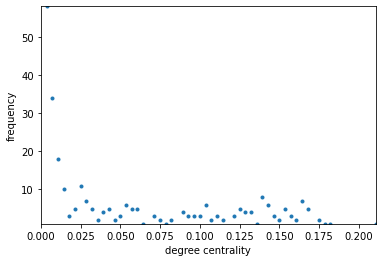

In [47]:
#ako ima nekoliko koji se izdvajaju sa velikom centralnoscu - centralizovan
#nas nije
plot_players_per_centralities_frequency(G)

In [48]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G)) 
  
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G))

#treba mnogo vremena!!!
#nx.average_node_connectivity(G)

1
1


# 16. Koje su prosečne distance, a koliki dijametar u okviru modelovanih mreža?

In [49]:
#ovoga vise nema kad smo izbacili Davis Cup!
# for g in [G.subgraph(c) for c in nx.connected_components(G)]: 
#     if len(g.nodes())<=4:
#         small_components=get_players_info(g.nodes())
#     if len(g.nodes())==19:
#         one_bigger_component=getPlayersInfo(g.nodes())
        
if nx.is_connected(G):
    print(f'Prosecna distanca: {(nx.average_shortest_path_length(G))}')
    print(f'Dijametar: {nx.diameter(G)}')

Prosecna distanca: 2.685892221657346
Dijametar: 7


# 17. Kakva je distribucija čvorova po stepenu i da li prati neku zakonomernost? Kako je stepen čvora korelisan sa rejtingom tenisera?

Counter({1: 58, 2: 34, 3: 18, 7: 11, 4: 10, 39: 8, 8: 7, 46: 7, 40: 6, 29: 6, 15: 6, 9: 5, 43: 5, 17: 5, 16: 5, 12: 5, 35: 5, 47: 5, 6: 5, 25: 4, 11: 4, 36: 4, 37: 4, 5: 3, 20: 3, 31: 3, 27: 3, 14: 3, 26: 3, 28: 3, 44: 3, 34: 3, 41: 3, 45: 2, 30: 2, 13: 2, 49: 2, 42: 2, 21: 2, 10: 2, 23: 2, 32: 2, 38: 1, 18: 1, 22: 1, 51: 1, 50: 1, 59: 1})


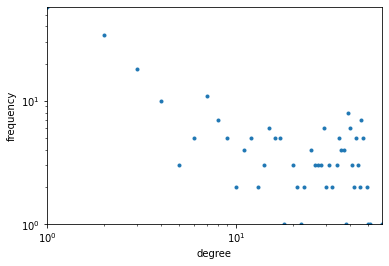

In [50]:
plot_deg_frequency(G, weighted=False)

In [51]:
def plot_deg_distribution(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    fig = plt.figure(1)
    plt.ylabel('degree')
    plt.ylabel('Broj cvorova')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(degree,frequency)
    plt.show()

Counter({1: 58, 2: 34, 3: 18, 7: 11, 4: 10, 39: 8, 8: 7, 46: 7, 40: 6, 29: 6, 15: 6, 9: 5, 43: 5, 17: 5, 16: 5, 12: 5, 35: 5, 47: 5, 6: 5, 25: 4, 11: 4, 36: 4, 37: 4, 5: 3, 20: 3, 31: 3, 27: 3, 14: 3, 26: 3, 28: 3, 44: 3, 34: 3, 41: 3, 45: 2, 30: 2, 13: 2, 49: 2, 42: 2, 21: 2, 10: 2, 23: 2, 32: 2, 38: 1, 18: 1, 22: 1, 51: 1, 50: 1, 59: 1})


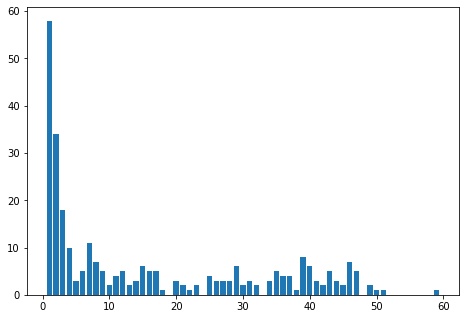

In [52]:
plot_deg_distribution(G)
#plot_deg_distribution(G, weighted=True)

In [53]:
def plot_rank_degree(G, weight=True, xscale = "log", yscale = "log"):

    if (weight):
        rank_degree = [(rank,G.degree(weight='weight')[node]) for node,rank in G.nodes(data='rank')]
    else:
        rank_degree = [(rank,G.degree()[node]) for node,rank in G.nodes(data='rank')]
    rank, degree = zip(*rank_degree)                                                      

    plt.figure(1)   

    # prep axes   
    plt.xlabel('rank')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(rank))  

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(degree))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(rank, degree, marker='.')                                                                                                    
    plt.show()

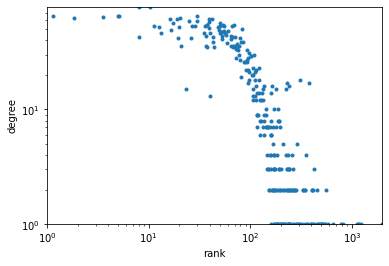

In [54]:
plot_rank_degree(G)

# 18. Da li u mreži postoje habovi i koji su? 

In [55]:
hubs,authorities = nx.hits(G)

high_hubs_players = [(get_player_info(node), h) for node,h in sorted(hubs.items(), key=lambda element: (element[1]),reverse=True)][:10]

high_hubs_players

#moze i eigen_vector

[((126774, 'Stefanos Tsitsipas', 8.0, 'GRE'), 0.01927962420018486),
 ((106421, 'Daniil Medvedev', 10.352941176470589, 'RUS'),
  0.017673423886142986),
 ((103819, 'Roger Federer', 3.549019607843137, 'SUI'), 0.01593159446583423),
 ((104925, 'Novak Djokovic', 1.1568627450980393, 'SRB'), 0.015843302337860878),
 ((106233, 'Dominic Thiem', 5.098039215686274, 'AUT'), 0.015514739978732294),
 ((104745, 'Rafael Nadal', 1.8431372549019607, 'ESP'), 0.015329668449704788),
 ((126610, 'Matteo Berrettini', 29.58823529411765, 'ITA'),
  0.014877683210084525),
 ((105676, 'David Goffin', 19.058823529411764, 'BEL'), 0.014244651386292443),
 ((100644, 'Alexander Zverev', 4.96078431372549, 'GER'), 0.01421656137585437),
 ((105526, 'Jan Lennard Struff', 41.98039215686274, 'GER'),
  0.013233945276642223)]

# 19. Da li mreža tenisera iskazuje osobine malog sveta?
A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

In [56]:
# #sigma>1
# sigma = nx.sigma(G)

# #~0
# omega = nx.omega(G)

# 20. Kakve su karakteristike ego mreža članova Velike trojke? U kojoj meri se te karakteristike razlikuju?

In [57]:
def get_average_ranks(G):
    ranks = [rank for node,rank in G.nodes(data='rank')]
    return sum(ranks)/len(ranks)

In [58]:
novak_id = get_player_by_name("Novak Djokovic")
rafa_id = get_player_by_name("Rafael Nadal")
federer_id = get_player_by_name("Roger Federer")

novak_ego_graph = nx.ego_graph(G,novak_id)
print(f"Novakova ego mreza : {nx.info(novak_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(novak_ego_graph)}")
print(f"Gustina mreze : {nx.density(novak_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(novak_ego_graph)}")
novak_degree_centrality = [centrality for node, centrality in nx.degree_centrality(novak_ego_graph).items() if node==novak_id]
novak_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(novak_ego_graph).items() if node==novak_id]
print(f"Degree centrality : {novak_degree_centrality}")
print(f"Eigenvector centrality : {novak_eigenvector_centrality}")
print("\n")

rafa_ego_graph = nx.ego_graph(G,rafa_id)
print(f"Nadalova ego mreza : {nx.info(rafa_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(rafa_ego_graph)}")
print(f"Gustina mreze : {nx.density(rafa_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(rafa_ego_graph)}")
rafa_degree_centrality = [centrality for node, centrality in nx.degree_centrality(rafa_ego_graph).items() if node==rafa_id]
rafa_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(rafa_ego_graph).items() if node==rafa_id]
print(f"Degree centrality : {rafa_degree_centrality}")
print(f"Eigenvector centrality : {rafa_eigenvector_centrality}")
print("\n")

federer_ego_graph = nx.ego_graph(G,federer_id)
print(f"Federerova ego mreza : {nx.info(federer_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(federer_ego_graph)}")
print(f"Gustina mreze : {nx.density(federer_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(federer_ego_graph)}")
federer_degree_centrality = [centrality for node, centrality in nx.degree_centrality(federer_ego_graph).items() if node==federer_id]
federer_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(federer_ego_graph).items() if node==federer_id]
print(f"Degree centrality : {federer_degree_centrality}")
print(f"Eigenvector centrality : {federer_eigenvector_centrality}")

Novakova ego mreza : Name: 
Type: Graph
Number of nodes: 45
Number of edges: 316
Average degree:  14.0444
Prosecan tezinski stepen : 19.2
Gustina mreze : 0.3191919191919192
Prosecan rank tenisera mreze : 53.859259259259254
Degree centrality : [1.0]
Eigenvector centrality : [0.3259250875135497]


Nadalova ego mreza : Name: 
Type: Graph
Number of nodes: 48
Number of edges: 366
Average degree:  15.2500
Prosecan tezinski stepen : 20.5
Gustina mreze : 0.324468085106383
Prosecan rank tenisera mreze : 63.73988970588235
Degree centrality : [1.0]
Eigenvector centrality : [0.3102351140802617]


Federerova ego mreza : Name: 
Type: Graph
Number of nodes: 47
Number of edges: 370
Average degree:  15.7447
Prosecan tezinski stepen : 21.361702127659573
Gustina mreze : 0.3422756706753006
Prosecan rank tenisera mreze : 52.48268669169795
Degree centrality : [1.0]
Eigenvector centrality : [0.32263402498819416]


In [59]:
novak_nodes = set(novak_ego_graph.nodes())
rafa_nodes = set(rafa_ego_graph.nodes())
federer_nodes = set(federer_ego_graph.nodes())

novak_rafa_node = novak_nodes.intersection(rafa_nodes)
novak_federer_node = novak_nodes.intersection(federer_nodes)
rafa_federer_node = rafa_nodes.intersection(federer_nodes)

print(f"Novak i Rafa: {len(novak_rafa_node)}")
print(f" {get_players_info(novak_rafa_node)}")
print("\n")
print(f"Novak i Federer: {len(novak_federer_node)}")
print(f" {get_players_info(novak_federer_node)}")
print("\n")
print(f"Federer i Rafa: {len(rafa_federer_node)}")
print(f" {get_players_info(rafa_federer_node)}")

Novak i Rafa: 23
 [(105227, 'Marin Cilic', 19.431372549019606, 'CRO'), (103819, 'Roger Federer', 3.549019607843137, 'SUI'), (105357, 'John Millman', 52.72549019607843, 'AUS'), (126610, 'Matteo Berrettini', 29.58823529411765, 'ITA'), (100644, 'Alexander Zverev', 4.96078431372549, 'GER'), (104871, 'Jeremy Chardy', 54.411764705882355, 'FRA'), (104745, 'Rafael Nadal', 1.8431372549019607, 'ESP'), (105777, 'Grigor Dimitrov', 36.333333333333336, 'BUL'), (105138, 'Roberto Bautista Agut', 16.058823529411764, 'ESP'), (106421, 'Daniil Medvedev', 10.352941176470589, 'RUS'), (133430, 'Denis Shapovalov', 25.11764705882353, 'CAN'), (126774, 'Stefanos Tsitsipas', 8.0, 'GRE'), (105526, 'Jan Lennard Struff', 41.98039215686274, 'GER'), (106043, 'Diego Sebastian Schwartzman', 20.11764705882353, 'ARG'), (105023, 'Sam Querrey', 53.21568627450981, 'USA'), (105932, 'Nikoloz Basilashvili', 19.686274509803923, 'GEO'), (105676, 'David Goffin', 19.058823529411764, 'BEL'), (104527, 'Stanislas Wawrinka', 28.8823529

# 21. Kakva je pozicija ego čvora u svakoj od ego mreža? Kako su oni strukturno ugrađeni u mrežu?

In [60]:
novak_edges = [edge for edge in novak_ego_graph.edges(nbunch=novak_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Novakovih veza = {len(novak_edges)*100/len(edges)}")

rafa_edges = [edge for edge in rafa_ego_graph.edges(nbunch=rafa_id)]
edges = rafa_ego_graph.edges()

print(f"Procenat Nadalovih veza = {len(rafa_edges)*100/len(edges)}")

federer_edges = [edge for edge in federer_ego_graph.edges(nbunch=federer_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Federerovih veza = {len(federer_edges)*100/len(edges)}")

Procenat Novakovih veza = 13.924050632911392
Procenat Nadalovih veza = 12.841530054644808
Procenat Federerovih veza = 14.556962025316455


# 22. Kako su posmatrane ego mreže ugrađene u mrežu tenisera?

In [61]:
novak_ego_edges = [edge for edge in novak_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Novakovih veza u ego i obicnoj mrezi = {len(novak_ego_edges)*100/len(edges)}")
print(f"Procenat Novakovih suparnika u obicnoj mrezi = {len(novak_nodes)*100/len(G.nodes())}")

Procenat Novakovih veza u ego i obicnoj mrezi = 14.266365688487584
Procenat Novakovih suparnika u obicnoj mrezi = 16.01423487544484


In [62]:
rafa_ego_edges = [edge for edge in rafa_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Nadalovih veza u ego i obicnoj mrezi = {len(rafa_ego_edges)*100/len(edges)}")
print(f"Procenat Nadalovih suparnika u obicnoj mrezi = {len(rafa_nodes)*100/len(G.nodes())}")

Procenat Nadalovih veza u ego i obicnoj mrezi = 16.52370203160271
Procenat Nadalovih suparnika u obicnoj mrezi = 17.081850533807827


In [63]:
federer_ego_edges = [edge for edge in federer_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Federerovih veza u ego i obicnoj mrezi = {len(federer_ego_edges)*100/len(edges)}")
print(f"Procenat Federerovih suparnika u obicnoj mrezi = {len(federer_nodes)*100/len(G.nodes())}")

Procenat Federerovih veza u ego i obicnoj mrezi = 16.704288939051917
Procenat Federerovih suparnika u obicnoj mrezi = 16.725978647686834


# 23. Analizirati mrežu dobijenu unifikacijom ego mreža članova Velike trojke.
## Koji procenat čvorova mreže svih tenisera učestvuje u njoj?
## Sprovesti klasterisanje ovako dobijene mreže na tri klastera i na osnovu dobijenih rezultata dati interpretaciju kriterijuma pripadnosti klasterima.


In [64]:
all_edges = set(novak_ego_edges).union(set(rafa_ego_edges)).union(set(federer_ego_edges))

u = G.edge_subgraph(all_edges)
print(f"Unificirana mreza : {nx.info(u)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(u)}")
print(f"Gustina mreze : {nx.density(u)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(u)}")

Unificirana mreza : Name: 
Type: Graph
Number of nodes: 85
Number of edges: 684
Average degree:  16.0941
Prosecan tezinski stepen : 20.988235294117647
Gustina mreze : 0.1915966386554622
Prosecan rank tenisera mreze : 73.42520184544405


In [65]:
print(f"Procenat cvorova u unificirano mrezi = {len(u.nodes())*100/len(G.nodes())}")

Procenat cvorova u unificirano mrezi = 30.249110320284696


In [66]:
data = u.nodes()
edge_mat = nx.to_numpy_matrix(u,nodelist=data,weight='weight')

kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_mat)

#initialize dict
clusters = {}
for index in range(0,3): 
    nodes = []    
    clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    clusters[cluster_info[1]].append(cluster_info[0])
clusters

{0: [105216,
  105223,
  106000,
  104731,
  103970,
  104999,
  106283,
  104755,
  106045,
  104259,
  200005,
  105554,
  106071,
  105051,
  104797,
  104545,
  111202,
  120424,
  144750,
  134770,
  106099,
  105077,
  105870,
  104607,
  105376,
  106148,
  200615,
  105643,
  144895,
  105902,
  106423,
  132283,
  126652,
  106432,
  105173,
  105430,
  104919,
  111576,
  111577,
  106214,
  106216,
  104424,
  105967,
  106228],
 1: [128034,
  100644,
  104745,
  126774,
  133430,
  104527,
  103819,
  126610,
  105138,
  106421,
  105676,
  104925,
  106233],
 2: [105732,
  105227,
  105777,
  105526,
  106298,
  106043,
  105023,
  200000,
  104269,
  105550,
  105807,
  104792,
  200282,
  104542,
  105311,
  106378,
  105357,
  126094,
  106401,
  104871,
  105916,
  105932,
  105936,
  111575,
  104926,
  105453,
  126203,
  126207]}

In [67]:
N = len(u.nodes())

num_of_ego_graphs = {}
for node in u.nodes():
    n = 1 if node in novak_ego_graph else 0
    r = 1 if node in rafa_ego_graph else 0
    f = 1 if node in federer_ego_graph else 0
    num_of_ego_graphs[node] = n+r+f

edge_matrix =  np.array([[0 for i in range(2)]] * N )
node_index = 0
for node in u.nodes():
    for neighbor in u.neighbors(node):
        neighbor_index = list(u.nodes()).index(neighbor)
        edge_matrix[node_index,1] = num_of_ego_graphs[node]
    node_index+=1
        
edge_matrix

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 3],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 3],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 3],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0,

In [68]:
kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_matrix)

#initialize dict
big_three_clusters = {}
for index in range(0,3): 
    nodes = []    
    big_three_clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    big_three_clusters[cluster_info[1]].append(cluster_info[0])
big_three_clusters

{0: [100644,
  104745,
  105777,
  126774,
  133430,
  104527,
  104542,
  103819,
  105357,
  126610,
  105138,
  106421,
  105676,
  104925,
  105453,
  106228,
  106233],
 1: [105216,
  105732,
  105223,
  104731,
  103970,
  104999,
  106283,
  104755,
  106045,
  200000,
  200005,
  105550,
  105807,
  106071,
  105051,
  104797,
  111202,
  120424,
  144750,
  134770,
  106099,
  105077,
  126094,
  105870,
  104607,
  105376,
  106401,
  106148,
  200615,
  105643,
  144895,
  105902,
  106423,
  132283,
  126652,
  106432,
  105173,
  105430,
  111575,
  111576,
  111577,
  104926,
  106214,
  106216,
  104424,
  105967,
  126207],
 2: [105227,
  106000,
  128034,
  105526,
  106298,
  106043,
  105023,
  104259,
  104269,
  105554,
  104792,
  200282,
  105311,
  104545,
  106378,
  104871,
  105916,
  105932,
  105936,
  104919,
  126203]}

In [69]:
def get_players_cluster(id):
    for cluster_index in range(0,3):
        if id in clusters[cluster_index]:
            return cluster_index

In [70]:
get_players_cluster(novak_id)

1

In [71]:
get_players_cluster(rafa_id)

1

In [72]:
get_players_cluster(federer_id)

1

# 24. Kakva je distribucija broja tenisera u odnosu na broj mečeva koji su odigrali?

Counter({1: 57, 2: 35, 3: 18, 7: 10, 4: 10, 8: 7, 53: 7, 36: 7, 9: 5, 46: 5, 12: 5, 6: 5, 15: 5, 18: 4, 16: 4, 43: 4, 14: 4, 5: 3, 22: 3, 34: 3, 17: 3, 26: 3, 62: 3, 65: 3, 44: 3, 35: 3, 39: 3, 52: 3, 42: 3, 10: 3, 13: 3, 55: 2, 49: 2, 59: 2, 33: 2, 20: 2, 48: 2, 63: 2, 54: 2, 30: 2, 57: 2, 21: 2, 28: 2, 47: 2, 29: 2, 27: 2, 41: 2, 23: 2, 79: 2, 61: 1, 50: 1, 19: 1, 45: 1, 58: 1, 51: 1, 64: 1, 66: 1, 37: 1, 38: 1, 31: 1})


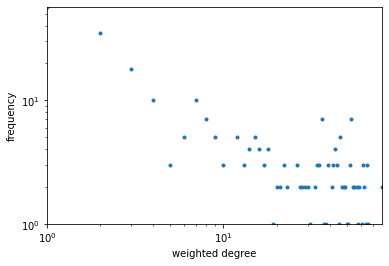

In [73]:
plot_deg_frequency(G, weighted = True)

# 25. Kakva je distribucija broja turnira u odnosu na podlogu i godinu održavanja?

In [74]:
def plot_tourney_per_surface_frequency(G, xscale = "linear", yscale = "linear"):

    surfaces = [surface for node,surface in G.nodes(data='surface')]
    surfaces_counts = Counter(surfaces) #prebrojava, 1, 2, ..        
    surfaces_counts = (sorted(surfaces_counts.items(), key=lambda element: (element[1]),reverse=True))
    print(surfaces_counts)
    surface, num_of_tourneys = zip(*surfaces_counts)                                                      

    fig = plt.figure(1)   
    plt.ylabel('num of tourneys')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(surface,num_of_tourneys)
    plt.show()

[('Hard', 37), ('Clay', 21), ('Grass', 8)]


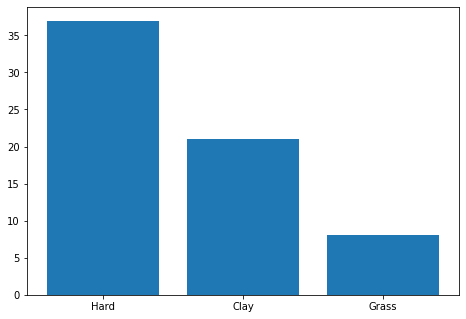

In [75]:
tourney_sub_graph = tourney_graph.subgraph(tourney_nodes)

plot_tourney_per_surface_frequency(tourney_sub_graph)

# 26. Kakva je distribucija broja mečeva u odnosu na podlogu i godinu održavanja?

In [76]:
def plot_matches_per_surface_frequency(G, xscale = "linear", yscale = "linear"):

    data = [(surface,int((tourney_graph.degree(node,weight="weight"))/2)) for node,surface in tourney_graph.nodes(data='surface') if  node in tourney_names]

    dictionary = dict()
    for (surface, val) in data: 
        dictionary[surface] = dictionary.get(surface, 0) + val  # return the value for that key or return default 0 (and create key)
    surface=list(dictionary.keys())
    num_of_matches=list(dictionary.values())
    print(dictionary)

    fig = plt.figure(1)   
  
    ax = fig.add_axes([0,0,1,1])
    ax.bar(surface,num_of_matches)
    plt.show()

{'Hard': 1502, 'Clay': 783, 'Grass': 324}


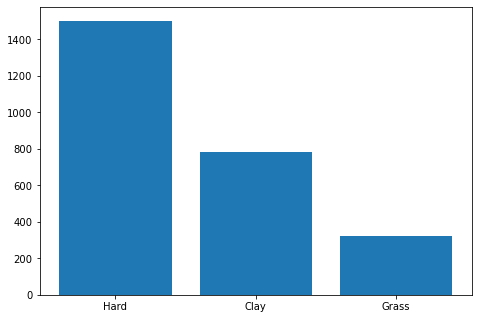

In [77]:
plot_matches_per_surface_frequency(tourney_graph)

#u proseku na svakom turniru po 40 meceva

# Cuvanje grafa

In [78]:
nx.write_gexf(G,output_gz_path)

# Vizuelizacija

In [79]:
def get_gephi_rank_group(rank):
    if rank<10:
        return 'group10'
    if rank<20:
        return 'group20'
    if rank<50:
        return 'group50'
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'group2000'

def add_gephi_rank_group_attribute(G):
    for player in G.nodes:
        G.nodes[player]['rank_group']=get_gephi_rank_group(G.nodes[player]['rank'])
        
def reverse_rank(G):
    for player in G.nodes:
        rank = G.nodes[player]['rank']
        G.nodes[player]['rank']=-rank if not np.isnan(rank) else -float(2000)

def set_ego_node_attribute(G,ego_nodes,ego_type):  
    for player in G.nodes:
        G.nodes[player]['node_type']=ego_type if player in ego_nodes else 'not_ego_node'
        
def set_ego_edge_attribute(G,ego_edges,ego_type):         
    for (source,target) in G.edges:
        G.edges[source,target]['edge_type']=ego_type if (((source,target) in ego_edges) | ((target,source) in ego_edges)) else 'not_ego_edge'          
        
def set_ego_attribute(G,ego_nodes,ego_edges,ego_type):  
    set_ego_node_attribute(G,ego_nodes,ego_type)
    set_ego_edge_attribute(G,ego_edges,ego_type)

def set_community_attribute(G):
    for key, values in communities_info.items():
        for value in values:
            G.nodes[value[0]]['community'] = key

def set_cluster_attribute(G):
    for key, values in clusters.items():
        for value in values:
            G.nodes[value]['cluster'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
        
def set_big_three_clusters_attribute(G):
    for key, values in big_three_clusters.items():
        for value in values:
            G.nodes[value]['big_three_clusters'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
       

In [82]:
def relable(G):
    values = [name for node,name in G.nodes(data='player_name')]
    mapping  = dict(zip(G, values))

    return  nx.relabel_nodes(G, mapping)   

def arrange_graph(G):
    H = copy.deepcopy(G)

    add_gephi_rank_group_attribute(H)
    
    reverse_rank(H)    
    return relable(H)

def arrange_ego_in_graph(G,nodes,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_attribute(H,nodes,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_ego_graph(G,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_edge_attribute(H,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_communities(G):
    H = copy.deepcopy(G)
    
    set_community_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_clusters(G):
    H = copy.deepcopy(G)
    
    set_cluster_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_big_three_clusters(G):
    H = copy.deepcopy(G)
    
    set_big_three_clusters_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

In [83]:
nx.write_gml(arrange_graph(G), output_gml_path)

nx.write_gml(arrange_ego_in_graph(G,novak_nodes,novak_ego_edges,'novak'), "novak_ego_in_2019.gml")
nx.write_gml(arrange_ego_in_graph(G,rafa_nodes,rafa_ego_edges,'rafa'), "rafa_ego_in_2019.gml")
nx.write_gml(arrange_ego_in_graph(G,federer_nodes,federer_ego_edges,'federer'), "federer_ego_in_2019.gml")

nx.write_gml(arrange_ego_graph(novak_ego_graph,novak_edges,'novak'), "novak_ego_graph_2019.gml")
nx.write_gml(arrange_ego_graph(rafa_ego_graph,rafa_edges,'rafa'), "rafa_ego_graph_2019.gml")
nx.write_gml(arrange_ego_graph(federer_ego_graph,federer_edges,'federer'), "federer_ego_graph_2019.gml")

nx.write_gml(arrange_communities(G), "communities_2019.gml")
nx.write_gml(arrange_clusters(u), "clusters_unified_graph_2019.gml")

#asyn_fluid_clusters
#nx.write_gml(arrange_asyn_fluid_clusters(u), "asyn_fluid_clusters_unified_graph_2019.gml")

nx.write_gml(arrange_big_three_clusters(u), "big_three_clusters_unified_graph_2019.gml")